In [294]:
import pandas as pd
import numpy as np

data = pd.read_csv('train.csv')
y = data['SalePrice']
X = data.drop(['Id', 'SalePrice'], axis=1)

Text(0.5, 1.0, 'Distribution of Housing Prices')

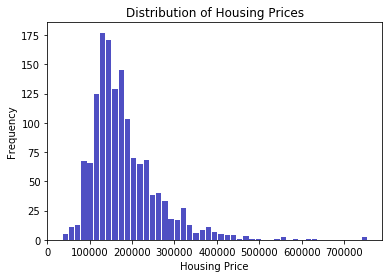

In [9]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=y, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('Housing Price')
plt.ylabel('Frequency')
plt.title('Distribution of Housing Prices')

In [312]:
X.shape

(1460, 79)

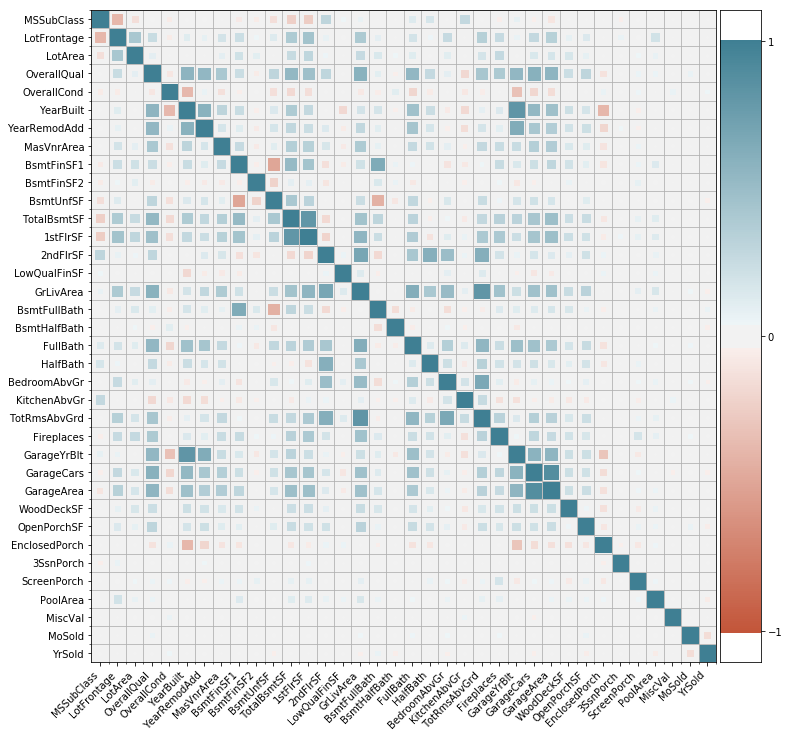

In [310]:
from heatmap import corrplot
plt.figure(figsize=(12, 12))
corrplot(X._get_numeric_data().corr(), size_scale=250, marker='s')

## High Correlations
* YearBuilt x GarageYrBlt
* GrLivArea x TotRmsAbvGrd
* 1stFlrSF x TotalBsmt
* GarageCars X GarageArea

## Missing Values

In [324]:
X.isnull().sum()[X.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [339]:
X['LotFrontage'] = X['LotFrontage'].fillna(0)
X['MasVnrArea'] = X['MasVnrArea'].fillna(0)
X['GarageYrBlt'] = X['GarageYrBlt'].fillna(X['YearBuilt']) #group and make categorical


## Categorical

In [344]:
X.select_dtypes(exclude=['object']).nunique()
# Convert 'MSSubClass', 'OverallQual', 'OverallCond' to categorical

MSSubClass         15
LotFrontage       111
LotArea          1073
OverallQual        10
OverallCond         9
YearBuilt         112
YearRemodAdd       61
MasVnrArea        327
BsmtFinSF1        637
BsmtFinSF2        144
BsmtUnfSF         780
TotalBsmtSF       721
1stFlrSF          753
2ndFlrSF          417
LowQualFinSF       24
GrLivArea         861
BsmtFullBath        4
BsmtHalfBath        3
FullBath            4
HalfBath            3
BedroomAbvGr        8
KitchenAbvGr        4
TotRmsAbvGrd       12
Fireplaces          4
GarageYrBlt       102
GarageCars          5
GarageArea        441
WoodDeckSF        274
OpenPorchSF       202
EnclosedPorch     120
3SsnPorch          20
ScreenPorch        76
PoolArea            8
MiscVal            21
MoSold             12
YrSold              5
dtype: int64

In [140]:
from sklearn.model_selection import train_test_split

test_size = .3
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size)

In [369]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

numeric_features = list(X.select_dtypes(exclude=['object']).columns)
numeric_features = [e for e in numeric_features if e 
                    not in ('MSSubClass', 'OverallQual', 'OverallCond')]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_features = list(X.select_dtypes(include=['object']).columns)
categorical_features.extend(['MSSubClass', 'OverallQual', 'OverallCond'])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



In [400]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_log_error, r2_score
import xgboost as xgb

#xgboost = xgb.XGBRegressor(max_depth=4,
#                           colsample_bytree=0.6,
#                           subsample=0.8,
#                           reg_alpha=110,
#                           learning_rate=0.005,
#                           n_estimators=6000,
#                           nthread=4, seed=27)

xgboost = xgb.XGBRegressor(max_depth=4,
                           min_child_weight=3,
                           gamma=0,
                           colsample_bytree=0.85,
                           subsample=0.85,
                           reg_alpha=1,
                           learning_rate=0.05,
                           n_estimators=1000,
                           nthread=4, seed=27)

param_grid1 = {
    "xgboost__max_depth":range(3,10,2),
    'xgboost__min_child_weight':range(1,6,2)
}

param_grid2 = {
    "xgboost__max_depth":[2,3,4],
    'xgboost__min_child_weight':[2,3,4]
}

param_grid3 = {
 'xgboost__gamma':[i/10.0 for i in range(0,5)]
}

param_grid4 = {
 'xgboost__subsample':[i/10.0 for i in range(6,10)],
 'xgboost__colsample_bytree':[i/10.0 for i in range(6,10)]
}

param_grid5 = {
 'xgboost__subsample':[i/100.0 for i in range(85,100,5)],
 'xgboost__colsample_bytree':[i/100.0 for i in range(85,100,5)]
}

param_grid6 = {
 'xgboost__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

param_grid7 = {
 'xgboost__reg_alpha':[0.5, 1, 10]
}

param_grid8 = {
    "xgboost__n_estimators": [1000, 5000, 10000],
    "xgboost__learning_rate": [0.1, 0.05, 0.01],
}

param_grid9 = {
    "xgboost__n_estimators": [500, 1000, 1500],
    "xgboost__learning_rate": [0.08, 0.05, 0.03],
}


pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                      ('xgboost', xgboost)])
def rmsle(y, y0):
    return -np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))

search = GridSearchCV(pipe, param_grid9, cv=5,
                      scoring=make_scorer(rmsle))
search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...=None, seed=27, subsample=0.85,
       tree_method=None, validate_parameters=None, verbosity=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'xgboost__n_estimators': [500, 1000, 1500], 'xgboost__learning_rate': [0.08, 0.05, 0.03]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmsle), verbose=0)

In [401]:
#rmsle
search.cv_results_['mean_test_score']

array([-0.12920959, -0.12940356, -0.12944749, -0.12498386, -0.12467102,
       -0.12479802, -0.12871583, -0.12759395, -0.12753767])

In [402]:
search.best_params_

{'xgboost__learning_rate': 0.05, 'xgboost__n_estimators': 1000}

In [399]:
search.best_index_

3

In [403]:
X = preprocessor.fit_transform(X)

In [404]:
xgboost = xgb.XGBRegressor(max_depth=4,
                           min_child_weight=3,
                           gamma=0,
                           colsample_bytree=0.85,
                           subsample=0.85,
                           reg_alpha=1,
                           learning_rate=0.05,
                           n_estimators=1000,
                           nthread=4, seed=27)
xgboost.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.85, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.05, max_delta_step=0, max_depth=4,
       min_child_weight=3, missing=nan, monotone_constraints='()',
       n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
       objective='reg:squarederror', random_state=27, reg_alpha=1,
       reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.85,
       tree_method='exact', validate_parameters=1, verbosity=None)

In [405]:
test = pd.read_csv('test.csv')
X_test = preprocessor.transform(test)

In [406]:
prediction = xgboost.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':prediction})

submission.to_csv('Predictions/HousingPrices4.csv', index=False)